<a href="https://colab.research.google.com/github/syedayazsa/transfer-learning-for-segregation/blob/master/Xception_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING NECESSARY LIBRARIES**

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications import Xception
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


# **LOADING AND UNZIPPING THE DATASET**

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-18 16:17:33--  https://docs.google.com/uc?export=download&confirm=ROpv&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.138, 108.177.126.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-0s-docs.googleusercontent.com/docs/securesc/dmcoh0bhkkvmvr8fssi9emjvoj2jiia3/758l8pg2e3o5n1gotupdt8i4b2a73ftj/1589818650000/14211000813324722452/11472417864772028133Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-18 16:17:33--  https://doc-00-0s-docs.googleusercontent.com/docs/securesc/dmcoh0bhkkvmvr8fssi9emjvoj2jiia3/758l8pg2e3o5n1gotupdt8i4b2a73ftj/1589818650000/14211000813324722452/11472417864772028133Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-00-0s-docs.googleusercontent.com (doc-00-0s-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Conne

# **SPECIFIYING PATHS TO DIRECTORY**

In [0]:
from glob import glob
base_path = '/content/split_dataset'
folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/bullet_shells', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/bottles', '/content/split_dataset/train/boots', '/content/split_dataset/train/automatic_rifles', '/content/split_dataset/train/knives', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/syringes']


In [0]:
IMAGE_SIZE = [299, 299]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED Xception**

In [0]:
xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in xception.layers:
  layer.trainable = False

In [0]:
x = Flatten()(xception.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE Xception MODEL**

In [0]:
model_xception = Model(inputs=xception.input, outputs=prediction)
model_xception.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
model_xception.compile(
  loss='categorical_crossentropy',
  optimizer= 'adam',
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [0]:
history_xception = model_xception.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=5,
  verbose = 1,
  steps_per_epoch=400,
  validation_steps=80
)

Epoch 1/5
 24/400 [>.............................] - ETA: 5:28 - loss: 1.2019 - accuracy: 0.6406

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


400/400 [==============================] - 361s 902ms/step - loss: 0.3810 - accuracy: 0.8814 - val_loss: 0.0627 - val_accuracy: 0.9130
Epoch 2/5
400/400 [==============================] - 356s 891ms/step - loss: 0.2142 - accuracy: 0.9317 - val_loss: 0.0275 - val_accuracy: 0.9442
Epoch 3/5
400/400 [==============================] - 357s 893ms/step - loss: 0.1853 - accuracy: 0.9406 - val_loss: 0.1735 - val_accuracy: 0.9416
Epoch 4/5
400/400 [==============================] - 356s 889ms/step - loss: 0.1613 - accuracy: 0.9505 - val_loss: 0.1829 - val_accuracy: 0.9509
Epoch 5/5
400/400 [==============================] - 358s 895ms/step - loss: 0.1506 - accuracy: 0.9515 - val_loss: 0.0391 - val_accuracy: 0.9487


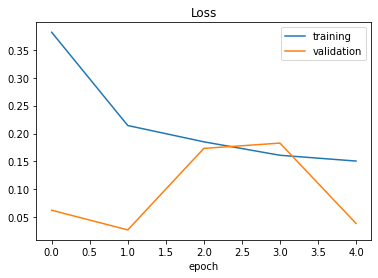

In [0]:
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

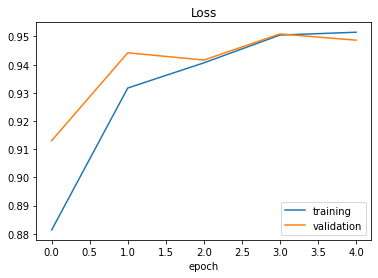

In [0]:
plt.plot(history_xception.history['accuracy'])
plt.plot(history_xception.history['val_accuracy'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_xception.save('/content/gdrive/My Drive/Model/xception.h5')

In [0]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle